In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!pip install -q kaggle

In [3]:
!mkdir ~/.kaggle

In [6]:
!cp kaggle.json ~/.kaggle/ #将json文件复制到指定路径下面
!chmod 600 ~/.kaggle/kaggle.json #设置文件读写权限
# !kaggle datasets list #test 查看kaggle数据集

In [7]:
!kaggle config set -n path -v /content/sample_data

- path is now set to: /content/sample_data


In [10]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
... resuming from 342884352 bytes (958608143 bytes left) ...
100% 1.21G/1.21G [00:10<00:00, 52.1MB/s]
100% 1.21G/1.21G [00:10<00:00, 91.6MB/s]


In [11]:
!unzip /content/gtzan-dataset-music-genre-classification.zip

Archive:  /content/gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating: Data/genres_original/blues/blues

In [31]:
#导入数据分析和绘图库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split #用于将数据集拆分为训练集和测试集
from sklearn.metrics import classification_report #用于生成分类任务的评估报告
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential #导入Sequential模型，用于构建连续序列模型

# 导入keras的卷积、全连接、池化、Dropout等层对应模块
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
# 编码映射库
from tensorflow.keras.utils import to_categorical

# import os,glob,skimage
import librosa #导入音频处理库
import librosa.display #导入音频显示模块，显示音频波形图和谱图等

In [32]:
dataframe = pd.read_csv('/content/Data/features_3_sec.csv')
dataframe.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [35]:
#数据预处理
#提取标签并删去不必要的列
classNames = list(set(dataframe['label']))
X = dataframe.drop(['filename','length','label'], axis = 1)

#根据流派名称构建标签，并完成独立热编码
Y_ = [classNames.index(i) for i in dataframe['label']]
Y = to_categorical(Y_)

### 划分数据集，测试集占比0.25，训练集占比0.75
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1, test_size=0.25)

from sklearn.preprocessing import StandardScaler
#对特征数据进行标准化处理，并确保列名保持一致
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [34]:
!pip install tensorflow_model_optimization

In [63]:
from tensorflow import keras
import tensorflow_model_optimization as tfmot
quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer

model = keras.models.Sequential([
  # quantize_annotate_layer(keras.layers.Dense(1024, activation='relu', kernel_initializer='glorot_uniform', input_shape=(X_train.shape[1],))),
  keras.layers.Dense(1024, activation='relu', kernel_initializer='glorot_uniform', input_shape=(X_train.shape[1],)),
  # keras.layers.Dropout(0.4),
  # keras.layers.BatchNormalization(),

  # quantize_annotate_layer(keras.layers.Dense(512, activation='relu', kernel_initializer='glorot_uniform')),
  keras.layers.Dense(512, activation='relu', kernel_initializer='glorot_uniform'),
  # keras.layers.Dropout(0.4),
  # keras.layers.BatchNormalization(),

  # quantize_annotate_layer(keras.layers.Dense(256, activation='relu', kernel_initializer='glorot_uniform')),
  keras.layers.Dense(256, activation='relu', kernel_initializer='glorot_uniform'),
  # keras.layers.Dropout(0.4),
  # keras.layers.BatchNormalization(),

  # quantize_annotate_layer(keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform')),
  keras.layers.Dense(128, kernel_initializer='glorot_uniform', activation='relu'),
  # keras.layers.Dropout(0.4),
  # keras.layers.BatchNormalization(),

  # quantize_annotate_layer(keras.layers.Dense(64, activation='relu', kernel_initializer='glorot_uniform')),
  keras.layers.Dense(64, kernel_initializer='glorot_uniform', activation='relu'),
  # keras.layers.Dropout(0.4),
  # keras.layers.BatchNormalization(),

  keras.layers.Dense(10, activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

origin = model.fit(X_train, Y_train, validation_split=0.3, epochs=20, batch_size=128, verbose=2)
# 打印网络结构
model.summary()

Epoch 1/20
41/41 - 2s - loss: 1.3222 - accuracy: 0.5421 - val_loss: 0.9262 - val_accuracy: 0.6739 - 2s/epoch - 59ms/step
Epoch 2/20
41/41 - 1s - loss: 0.7976 - accuracy: 0.7260 - val_loss: 0.7832 - val_accuracy: 0.7286 - 1s/epoch - 24ms/step
Epoch 3/20
41/41 - 1s - loss: 0.5815 - accuracy: 0.7979 - val_loss: 0.6787 - val_accuracy: 0.7665 - 1s/epoch - 36ms/step
Epoch 4/20
41/41 - 2s - loss: 0.4375 - accuracy: 0.8524 - val_loss: 0.5557 - val_accuracy: 0.8016 - 2s/epoch - 41ms/step
Epoch 5/20
41/41 - 1s - loss: 0.3235 - accuracy: 0.8888 - val_loss: 0.5598 - val_accuracy: 0.8167 - 1s/epoch - 25ms/step
Epoch 6/20
41/41 - 1s - loss: 0.2329 - accuracy: 0.9230 - val_loss: 0.5295 - val_accuracy: 0.8203 - 988ms/epoch - 24ms/step
Epoch 7/20
41/41 - 1s - loss: 0.1869 - accuracy: 0.9399 - val_loss: 0.5316 - val_accuracy: 0.8412 - 997ms/epoch - 24ms/step
Epoch 8/20
41/41 - 1s - loss: 0.1376 - accuracy: 0.9575 - val_loss: 0.4679 - val_accuracy: 0.8590 - 1s/epoch - 24ms/step
Epoch 9/20
41/41 - 1s - lo

In [64]:
predictions = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
# predictions = quantized_model.predict(X_test)
# score = quantized_model.evaluate(X_test, Y_test)
print('loss = ',score[0],'accuracy = ',score[1])

79/79 [==============================] - 0s 5ms/step - loss: 0.5311 - accuracy: 0.8791
loss =  0.5311356782913208 accuracy =  0.8791033029556274


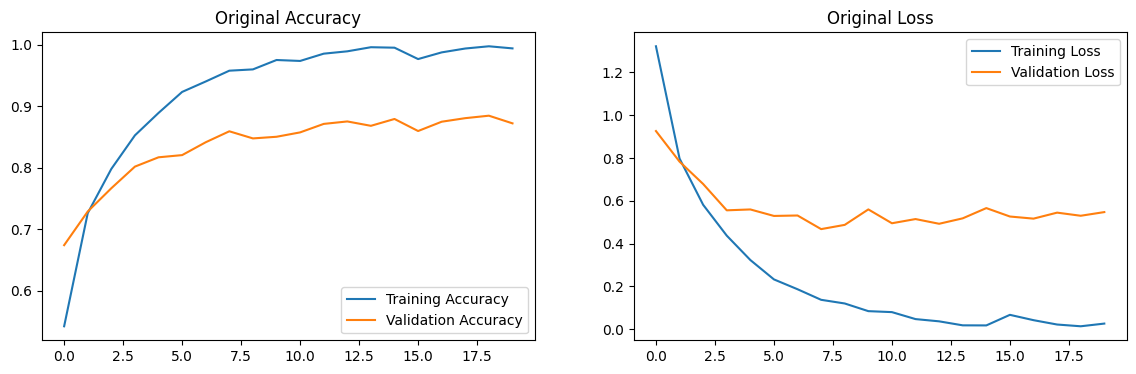

In [65]:
acc = origin.history['accuracy']
val_acc = origin.history['val_accuracy']

loss = origin.history['loss']
val_loss = origin.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Original Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Original Loss')
plt.show()

In [70]:
from tensorflow import keras
import tensorflow_model_optimization as tfmot
quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer

model = keras.models.Sequential([
  # 量化
  quantize_annotate_layer(keras.layers.Dense(1024, activation='relu', kernel_initializer='glorot_uniform', input_shape=(X_train.shape[1],))),
  # keras.layers.Dense(1024, activation='relu', kernel_initializer='glorot_uniform', input_shape=(X_train.shape[1],)),
  keras.layers.Dropout(0.4),
  keras.layers.BatchNormalization(),

  quantize_annotate_layer(keras.layers.Dense(512, activation='relu', kernel_initializer='glorot_uniform')),
  # keras.layers.Dense(512, activation='relu', kernel_initializer='glorot_uniform'),
  keras.layers.Dropout(0.4),
  keras.layers.BatchNormalization(),

  quantize_annotate_layer(keras.layers.Dense(256, activation='relu', kernel_initializer='glorot_uniform')),
  # keras.layers.Dense(256, activation='relu', kernel_initializer='glorot_uniform'),
  keras.layers.Dropout(0.4),
  keras.layers.BatchNormalization(),

  quantize_annotate_layer(keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform')),
  # keras.layers.Dense(128, kernel_initializer='glorot_uniform', activation='relu'),
  keras.layers.Dropout(0.4),
  keras.layers.BatchNormalization(),

  quantize_annotate_layer(keras.layers.Dense(64, activation='relu', kernel_initializer='glorot_uniform')),
  # keras.layers.Dense(64, kernel_initializer='glorot_uniform', activation='relu'),
  keras.layers.Dropout(0.4),
  keras.layers.BatchNormalization(),

  keras.layers.Dense(10, activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

add = model.fit(X_train, Y_train, validation_split=0.3, epochs=30, batch_size=128, verbose=2)
# 打印网络结构
model.summary()

Epoch 1/30
41/41 - 6s - loss: 2.4132 - accuracy: 0.2094 - val_loss: 1.7768 - val_accuracy: 0.4217 - 6s/epoch - 139ms/step
Epoch 2/30
41/41 - 1s - loss: 1.8210 - accuracy: 0.3650 - val_loss: 1.3968 - val_accuracy: 0.5440 - 1s/epoch - 32ms/step
Epoch 3/30
41/41 - 1s - loss: 1.5622 - accuracy: 0.4510 - val_loss: 1.2208 - val_accuracy: 0.5992 - 1s/epoch - 31ms/step
Epoch 4/30
41/41 - 1s - loss: 1.3973 - accuracy: 0.5151 - val_loss: 1.0893 - val_accuracy: 0.6303 - 1s/epoch - 32ms/step
Epoch 5/30
41/41 - 1s - loss: 1.2506 - accuracy: 0.5589 - val_loss: 0.9744 - val_accuracy: 0.6713 - 1s/epoch - 31ms/step
Epoch 6/30
41/41 - 1s - loss: 1.1516 - accuracy: 0.6135 - val_loss: 0.8993 - val_accuracy: 0.6922 - 1s/epoch - 30ms/step
Epoch 7/30
41/41 - 1s - loss: 1.0929 - accuracy: 0.6278 - val_loss: 0.8208 - val_accuracy: 0.7233 - 1s/epoch - 31ms/step
Epoch 8/30
41/41 - 1s - loss: 1.0299 - accuracy: 0.6606 - val_loss: 0.7817 - val_accuracy: 0.7407 - 1s/epoch - 31ms/step
Epoch 9/30
41/41 - 2s - loss: 0

In [71]:
predictions = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
# predictions = quantized_model.predict(X_test)
# score = quantized_model.evaluate(X_test, Y_test)
print('loss = ',score[0],'accuracy = ',score[1])

79/79 [==============================] - 1s 8ms/step - loss: 0.4249 - accuracy: 0.8767
loss =  0.4249407947063446 accuracy =  0.8767013549804688


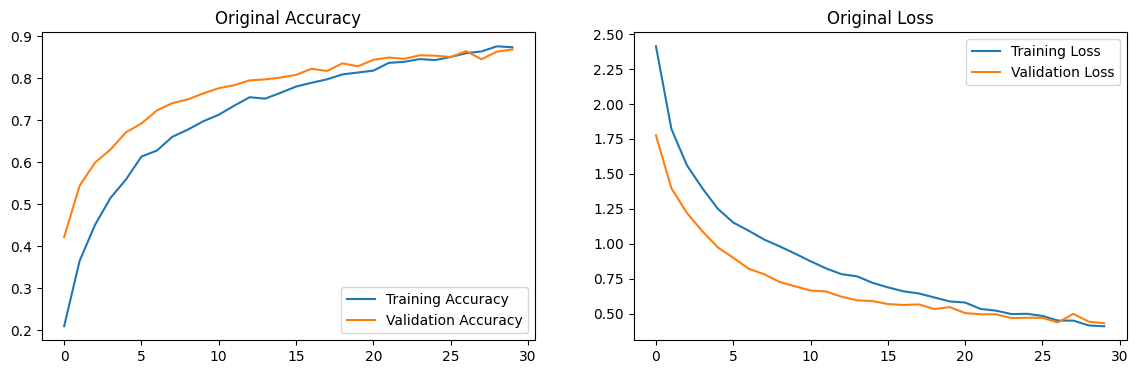

In [72]:
acc = add.history['accuracy']
val_acc = add.history['val_accuracy']

loss = add.history['loss']
val_loss = add.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Original Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Original Loss')
plt.show()